In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scipy.stats
import eqtk
import itertools


In [3]:
pwd = os.path.abspath('../..')
sys.path.append(os.path.join(pwd, 'code/')) 
import utilities
from utilities import *

Plan: Load pre-computed equlibrium concentrations generated by simulating 1-input dimerization networks of various sizes (3 monomers - 6 monomer species) with randomly sampled binding affinities and accessory monomer concentration (see 20220420_sim1inputTitration_randomParams.ipynb for details). 

To generate the network "output" we want to sum up the dimer concentrations at equlibrium with some non-negative weight for each dimer. Generate a set of output weights to apply across all simulations. Save the data and move to a new notebook to paramaterize and cluster the output. 

Note that the number of possible output weights scales exponentially with the number of dimers (which scales quadratically with the number of monomers). So if we have 3 possible output weight values (e.g. 0, 1, and 2), then for a 6 monomer network,  with 21 dimers, there are $3^{21}$ ~ $10^9$ possible output weight combinations. This is too many to compute exhaustivally at this point. Instead, use latin-hypercube sampling to generate a semi-random collection of output weights. One potential issue with LHS is that we may want many (or most) weights to be 0 and it's not obvious how to impose that constraint. In other words, we may want to impose a restriction on the number of active dimers. 

We could also restrict the total number of "active" dimers (i.e. dimers with non-zero output weights) and then, for a given sized network, permute which dimers are active. For example, suppose we allow 3 active dimers and their weights can be 1, 2 or 3. Then for a 6 node network (with 21 dimers) there are ~2000 ways to choose 3 'active dimers' and for each choice of active dimers, there are $3^3$ weight combinations, giving us ~18,000 weight vectors. 

In [14]:
def LHS_weights(n_dimers, k, lb=1, ub=10, 
                   centered = False, log = False, seed = 42):
    """
    Given n_dimers, sample k output weight vectors from 
    latin hypercube with lower bound = lb and upper bound = ub. 
    If log = True, then np.log10(lower bound) = lb and np.log10(upper bound) = ub.
    
    Returns
    -------
    out_weights : array_like, shape (k, n_dimers)
    """
    lhs_sampler =  scipy.stats.qmc.LatinHypercube(d=n_dimers, centered=centered, seed=seed)
    out_weights = lhs_sampler.random(n=k)
    out_weights = scipy.stats.qmc.scale(out_weights, [lb]*n_dimers, [ub]*n_dimers)
    if log:
        return np.power(10, out_weights)
    else:
        return out_weights
     


In [15]:
def make_weights_grid(n_dimensions, n_points, lb = 1, ub = 10):
    """
    Create grid of points from n_dimensions, each divided
    into n_points between lower bound = lb and upper bound = ub
    
    Returns
    -------
    weights_grid : array_like, shape (n_points**n_dimensions, n_dimensions)
        grid of output weights
    """
    weights_1d = np.linspace(lb, ub, n_points)
    mg = np.meshgrid(*[weights_1d]*n_dimensions, indexing='ij')
    weights_grid = np.vstack(list(map(np.ravel, mg)))
    return weights_grid.T

In [16]:
def sample_active_dimers_grid(total_dimers, active_dimers, 
                              n_points, lb, ub, log = False):
    """
    Create output weights matrices by constructing 
    a grid of nonzero output weights (n_points between lb and ub)
    and assigning them to a subset of 'active' dimers. The output
    weights for the remaining dimers is set to 0. 
    
    Returns
    -------
    out_weights : array_like, shape (n_points**active_dimers, total_dimers, total_dimers Choose active_dimers)
    """
    active_dimer_indices = itertools.combinations(np.arange(total_dimers), active_dimers)
    n_indices = math.comb(total_dimers, active_dimers)
    active_dimer_weights = make_weights_grid(active_dimers, n_points, lb=lb, ub=ub)
    if log:
        active_dimer_weights = np.power(10, active_dimer_weights)
    #There is probably a better way of doing the step below using fancy indexing
    #but I haven't figured it out yet. 
    out_weights = np.zeros((n_points**active_dimers, total_dimers, n_indices))
    for i, ind in enumerate(active_dimer_indices):
        out_weights[:,ind, i] = active_dimer_weights
    return out_weights
    

In [115]:
def compute_output_random_weights(n_monomers, n_weights, 
                                  sampling_method='LHS', lb=-3, ub=3, 
                                  n_active=3, log=True, centerLHS=False, 
                                  seed=42, save = False, outfileprefix = ''):
    """
    Load equil concentrations for network of size n_monomers simulated with semi-random parameters
    then generate semi-random output weights and compute dot product. 
    
    Parameters
    ----------
    n_monomers : int. 3 - 6 valid
        network size
    n_weights : int
        If sample_method == 'LHS', n_weights corresponds to the total number of weight vectors. 
        If sample_method == 'grid', n_weights corresponds to the number possible weights for 
        each 'active_dimer'. See sample_active_dimers_grid()
    sample_method : string, defaul 'LHS'.
        Method for sampling output weight vectors. Either 'LHS' or 'grid' 
    lb : int. Default -3
        Lower bound for output weight values. 
    ub : int. Defaul 3
        Upper bound for output weight values. 
    n_active : int. Default 3
        Number dimers with non-zero weights in each output weight vector.
        Only used if sample_method == 'grid.  See sample_active_dimers_grid()
    log : bool. Default True
        Place output weights on log scale
    centerLHS : bool. Default False. 
        see scipy.stats.qmc.LatinHypercube()
    seed : int. Default 42
    save : bool. Default False. 
    outfileprefix : string. Default ''. 
    
    Return
    ------
    out_weights : array_like, shape (n_dimers, n_weights)
    out : array_like, shape (S_all.shape[0], S_all.shape[2], n_weights) = (n_input_titration, n_param_univerese, n_weights) 
    """
    n_dimers = number_of_dimers(n_monomers)
    
    S_all = np.load(f'../../data/20220420_1input_randomParams/S_all_{n_monomers}M_1000k.npy')
    
    if sampling_method == 'LHS':
        out_weights = LHS_weights(n_dimers, n_weights, lb=lb, ub=ub, 
                   centered=False, log=True, seed=seed)
        #Transpose for matrix multiplication
        out_weights = out_weights.T
    elif sampling_method == 'grid':
        if n_weights > 10:
            raise ValueError('n_weights too large for sampling_method == "grid".\n \
            use smaller value or update function definition. ')
        out_weights = sample_active_dimers_grid(n_dimers, n_active,
                                  n_weights, lb=lb, ub=ub, log=log)
        #Rearrange axes and reshape for broadcasting matrix multiplication
        out_weights = np.moveaxis(out_weights, 1, 0)
        out_weights = out_weights.reshape(n_dimers, -1)
    else:
        raise ValueError('Unexpected choice for sampling_method. Please choose either LHS or grid')
        
    #Rearrange axes of S_all to broadcast matrix multiplication
    S_all = np.moveaxis(S_all, 2, 0)
    out = np.matmul(S_all[:,:,n_monomers:], out_weights)
    #Reshape out
    out = np.moveaxis(out, 1, 0)
    if save:
        np.save(f'{outfileprefix}out_weights_{n_monomers}M_{sampling_method}sample_{out_weights.shape[1]}k.npy', out_weights)
        np.save(f'{outfileprefix}output_{n_monomers}M_{sampling_method}sample_{out_weights.shape[1]}k.npy', out)

    return out_weights, out

In [116]:
outfileprefix = '../../data/20220420_1input_randomParams/'

In [121]:
for i in range(3,7):
    _, _ = \
    compute_output_random_weights(i, 1000, 
                              sampling_method='LHS', lb=-3, ub=3,
                              log=True, centerLHS=False, 
                              seed=42, save = True, outfileprefix = outfileprefix)

In [122]:
for i in range(3,7):
    _, _ = \
    compute_output_random_weights(i, 3, 
                              sampling_method='grid', lb=-3, ub=3,
                              n_active=3, log=True, centerLHS=False, 
                              seed=42, save = True, outfileprefix = outfileprefix)

In [99]:
saved_weights = np.load('../../data/20220420_1input_randomParams/out_weights_3M_gridsample_2500k.npy')
saved_out = np.load('../../data/20220420_1input_randomParams/output_3M_gridsample_2500k.npy')

In [120]:
for i in range(3,7):
    print(i)

3
4
5
6


In [119]:
test_out_LHS.shape

(10, 1000, 35910)

In [77]:
test_out_LHS.shape

(10, 1000000)

In [113]:
S_3M = np.load(f'../../data/20220420_1input_randomParams/S_all_{3}M_1000k.npy')

In [92]:
S_3M = np.moveaxis(S_3M, 2, 0)
out = np.matmul(S_3M[:,:,3:], test_weights_LHS)

In [114]:
S_3M.shape

(10, 9, 1000)

In [94]:
saved_out2 = saved_out.reshape(10,1000,2500)

In [95]:
saved_out2 = np.moveaxis(saved_out2, 0,1)

In [96]:
saved_out2.shape

(1000, 10, 2500)

In [97]:
np.all(out == saved_out2)

True

In [98]:
def plot_outcurves(outmat, facet = False, ylim=(-0.05,1.05), xticks = [0,4,9], xticklabels = [-3,0,3]):
    """
    """
    n_univ = outmat.shape[0]
    n_outweights = outmat.shape[2]
    n_titration = outmat.shape[1]
    
    xticklabels = [f'$10^{{{i}}}$' for i in xticklabels]
    if facet:
        fig, axes = plt.subplots(n_univ, n_outweights, figsize=(n_outweights*5, n_univ*5), squeeze=False, constrained_layout=True)
        for univ in range(n_univ):
            for weight in range(n_outweights):
                axes[(univ,weight)].plot(np.arange(n_titration), outmat[univ,:,weight])
                axes[(univ,weight)].set(aspect = 7, ylim=ylim, ylabel='out',
                                        xticks = xticks, xticklabels = xticklabels,
                                        title=f'univ: {univ}X weight:{weight}')
    else:
        fig, axes = plt.subplots(1, n_univ, figsize=(n_univ*5, 5), squeeze=False, constrained_layout=True)
        for univ in range(n_univ):
            for weight in range(n_outweights):
                axes[(0,univ)].plot(np.arange(n_titration), outmat[univ,:,weight], label=f'{weight}')
                axes[(0,univ)].set(aspect = 7, ylim=ylim, ylabel='out',
                                   xticks = xticks, xticklabels = xticklabels,
                                   title=f'univ: {univ}')
                axes[(0,univ)].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='weight set')

    return fig, axes
        
    

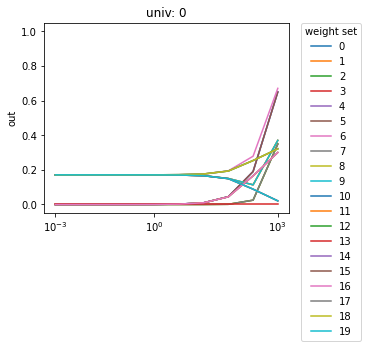

In [105]:
test_fig, test_axes = plot_outcurves(saved_out[:,0:20][np.newaxis,:,:])

In [107]:
saved_out[:,0:20].max()

0.6713405792852127

In [104]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [61]:
test_weights_grid, test_out_grid = \
compute_output_random_weights(5, 3, 
                              sampling_method='grid', lb=-3, ub=3, 
                              n_active=3, log=True, centerLHS=False, 
                              seed=42, save = False, outfileprefix = '')

In [62]:
test_weights_grid.shape

(15, 12285)

In [65]:
math.comb(15,3)

455

In [66]:
3**3*455

12285

In [60]:
number_of_dimers(5)

15

In [47]:
test_weights_grid.shape

(10, 15000)

In [48]:
test_out_grid.shape

(1000, 10, 15000)

In [42]:
test_out_grid_reshape = np.moveaxis(test_out_grid, 1, 0)
test_out_grid_reshape = test_out_grid_reshape.reshape(test_out_grid_reshape.shape[0], -1)

In [43]:
test_out_grid_reshape.shape

(10, 2500000)

In [44]:
test_out_grid_reshape[:,2]

array([1.27347944e-06, 1.27348914e-06, 1.27369819e-06, 1.27820251e-06,
       1.37528297e-06, 3.47058430e-06, 4.89860420e-05, 1.06516159e-03,
       2.49974811e-02, 3.49579698e-01])

In [45]:
test_out_grid[0,:,2]

array([1.27347944e-06, 1.27348914e-06, 1.27369819e-06, 1.27820251e-06,
       1.37528297e-06, 3.47058430e-06, 4.89860420e-05, 1.06516159e-03,
       2.49974811e-02, 3.49579698e-01])